# Демонстрация Net2Net
**Пояснение:** в ноутбуке реализован эксперимент с двуслойной нейросетью (матрица - ReLU - матрица).

Реализован метод net2net и две его модификации:
- net2net с сэмплированием через Gumbel-Softmax (в исходном Net2Net сэмплирование происходит случайно)
- net2net с "размазыванием" нейронов через softmax.

Критерий качества: устойчивость при добавлении шума в параметры.

NB: изначально я хотел использовать в качестве критерия FSGM-атаки, но оказалось (что вполне логично), что градиент, получаемый от всех методов одинаков и устойчивость к атакам также одинакова :(

In [1]:
import torch
import torchvision
import tqdm
import random
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


In [2]:
batch_size = 256
teacher_hidden = 20
student_hidden = 100

## Черновые прикидочные эксперименты

Пусть пока останутся здесь

In [3]:
# some tests
Wt1 = torch.randn(3,4)
Wt2 = torch.randn(4,2)
x = torch.randn(1, 3)
print (x@Wt1@Wt2)

Ws1 = torch.randn(3,5)
Ws2 = torch.randn(5,2)
Ws1[:,:3] = Wt1[:,:3]
Ws1[:,3] = Wt1[:,3]
Ws1[:,4] = Wt1[:,3]

Ws2[:3] = Wt2[:3]
Ws2[3] = Wt2[3]/2
Ws2[4] = Wt2[3]/2

print (x@Ws1@Ws2)


tensor([[-0.4979, -1.4378]])
tensor([[-0.4979, -1.4378]])


In [4]:
# some tests
teacher_hidden = 20
student_hidden = 100
inp = 784
out = 10

Wt1 = torch.randn(inp,teacher_hidden)
Wt2 = torch.randn(teacher_hidden,out)
x = torch.randn(1, inp)
print (x@Wt1@Wt2)

Ws1 = torch.randn(inp,student_hidden)
Ws2 = torch.randn(student_hidden,out)
Ws1[:,:teacher_hidden-1] = Wt1[:,:teacher_hidden-1]
for i in range(teacher_hidden-1, student_hidden):
    Ws1[:,i] = Wt1[:,teacher_hidden-1]

Ws2[:teacher_hidden-1] = Wt2[:teacher_hidden-1]
for i in range(teacher_hidden-1, student_hidden):
    Ws2[i] = Wt2[teacher_hidden-1]/(student_hidden - teacher_hidden + 1)

print (x@Ws1@Ws2)


tensor([[ 150.5751,   65.1792,  -55.6179,   98.8789, -263.1948,   70.9688,
           -6.8446, -225.7218,  119.5345, -271.9460]])
tensor([[ 150.5747,   65.1792,  -55.6180,   98.8788, -263.1952,   70.9688,
           -6.8447, -225.7222,  119.5342, -271.9459]])


In [5]:
# some tests
teacher_hidden = 20
student_hidden = 100
inp = 784
out = 10
mapping_num = [1]*teacher_hidden
mapping = {}
Wt1 = torch.randn(inp,teacher_hidden)
Wt2 = torch.randn(teacher_hidden,out)
x = torch.randn(1, inp)
print (x@Wt1@Wt2)

Ws1 = torch.randn(inp,student_hidden)
Ws2 = torch.randn(student_hidden,out)
Ws1[:,:teacher_hidden] = Wt1[:,:teacher_hidden]
for i in range(teacher_hidden, student_hidden):
    id = random.randint(0, teacher_hidden-1)
    mapping_num[id]+=1
    mapping[i] = id
    Ws1[:,i] = Wt1[:,id]

Ws2[:teacher_hidden] = Wt2[:teacher_hidden]
for i in range(student_hidden):
    id = mapping.get(i, i)
    num = mapping_num[id] 
    Ws2[i] = Wt2[id]/(num)

print (x@Ws1@Ws2)
print (abs((x@Ws1@Ws2 - x@Wt1@Wt2)).mean())

tensor([[ -10.3410, -194.3629,   57.7969,  236.8467,   40.6925, -116.4016,
          292.7987,  -14.9594,   28.4986, -161.6611]])
tensor([[ -10.3410, -194.3629,   57.7969,  236.8467,   40.6925, -116.4016,
          292.7987,  -14.9594,   28.4986, -161.6611]])
tensor(1.0395e-05)


In [7]:
Ws1, Ws2 = net2net(Wt1, Wt2, teacher_hidden, student_hidden, 10)

In [8]:
(torch.nn.functional.tanh(x@Ws1)@Ws2 - torch.nn.functional.tanh(x@Wt1)@Wt2).mean()

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(1.3113e-07)

## Обучение модели на MNIST

In [9]:

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)), torchvision.transforms.Lambda(torch.flatten)])),
  batch_size=batch_size, shuffle=False)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)), torchvision.transforms.Lambda(torch.flatten)])),
  batch_size=batch_size, shuffle=False)

In [10]:

teacher = torch.nn.Sequential(torch.nn.Linear(784, teacher_hidden, bias=False),
                              torch.nn.ReLU(), torch.nn.Linear(teacher_hidden, 10, bias=False))
crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(teacher.parameters())

for e in range(5):
    for x,y in tqdm.notebook.tqdm(train_loader):
        optim.zero_grad()
        out = teacher(x)
        loss = crit(out, y)
        loss.backward()
        optim.step()
    teacher.eval()
    total = 0
    correct = 0
    for x,y in test_loader:
        out = teacher(x)
        total+=out.shape[0]
        correct += torch.eq(out.argmax(1),y).sum()
    teacher.train()
    print (f'epoch {e}: {correct/total}')

  0%|          | 0/235 [00:00<?, ?it/s]

epoch 0: 0.9101999998092651


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 1: 0.9269000291824341


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 2: 0.9376000165939331


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 3: 0.9420999884605408


  0%|          | 0/235 [00:00<?, ?it/s]

epoch 4: 0.9434999823570251


## Исходный Net2Net

In [ ]:
def net2net(Wt1, Wt2, teacher_hidden, student_hidden, out_num, debug=False):
    mapping_num = [1]*teacher_hidden
    mapping = {}

    Ws1 = torch.randn(inp,student_hidden)
    Ws2 = torch.randn(student_hidden,out_num)
    Ws1[:,:teacher_hidden] = Wt1[:,:teacher_hidden]
    for i in range(teacher_hidden, student_hidden):
        if debug:
            id = teacher_hidden-1
        else:
            id = random.randint(0, teacher_hidden-1)
        mapping_num[id]+=1
        mapping[i] = id
        Ws1[:,i] = Wt1[:,id]

    Ws2[:teacher_hidden] = Wt2[:teacher_hidden]
    for i in range(student_hidden):
        id = mapping.get(i, i)
        num = mapping_num[id] 
        Ws2[i] = Wt2[id]/(num)
    return Ws1, Ws2

In [35]:
yplot = []
epses = [0.0, 0.01, 1e-3, 1e-2, 1e-1, 0.2, 0.3]
for _ in range(1):
    student = torch.nn.Sequential(torch.nn.Linear(784, student_hidden, bias=False),
                                  torch.nn.ReLU(), torch.nn.Linear(student_hidden, 10, bias=False))

    Wt1 = teacher[0].weight.T
    Wt2 = teacher[2].weight.T
    Ws1, Ws2 = net2net(Wt1, Wt2, teacher_hidden, student_hidden, 10)
    student[0].weight.data = Ws1.T 
    student[2].weight.data = Ws2.T 
    student.eval()
    yplot.append([])
    for e in tqdm.tqdm_notebook(epses):
        student[0].weight.data = Ws1.T + torch.randn(Ws1.T.shape)*e
        student[2].weight.data = Ws2.T+ torch.randn(Ws2.T.shape)*e
        total = 0
        correct = 0
        for x,y in test_loader:
            #x.requires_grad = True
            #student.zero_grad()
            out = student(x)
            #loss = crit(out, y)
            #loss.backward()
            #grad = x.grad
            
            #out = student(x + torch.sign(grad) * e)
            total+=out.shape[0]
            correct += torch.eq(out.argmax(1),y).sum()
            
        yplot[-1].append(correct/total)

<ipython-input-35-7871cb6c20f5>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm.tqdm_notebook(epses):


  0%|          | 0/7 [00:00<?, ?it/s]

## Net2Net с гумбель-софтмакс

При обучении оптимизируется критерий ||f(w, x) - f(w + eps, x)|| -> 0, при этом w должно давать те же значения выхода, что и исходной сети.

В процессе обучения постепенно минимизируется температура распределения (что делает распределение ближе к дискретному)

In [ ]:
def train_net2net(Wt1, Wt2, teacher_hidden, student_hidden, out_num,  train_loader, sigma, temp_schedule = [1.0, 0.5, 0.1, 1e-2, 1e-3],):
    weights = torch.nn.Parameter(torch.randn(student_hidden - teacher_hidden, teacher_hidden))
    optim = torch.optim.Adam([weights], lr=1e-1)
    
    for t in temp_schedule:
        tq = tqdm.tqdm_notebook(train_loader)
        losses = []
        #print (torch.distributions.RelaxedOneHotCategorical(t, logits = weights).probs)
        for x,y in tq:
            optim.zero_grad()
            weights_sm_ = torch.distributions.RelaxedOneHotCategorical(t, logits = weights).rsample()
            weights_sm = torch.cat([torch.eye(teacher_hidden), weights_sm_])
            Ws1 = Wt1 @ weights_sm.T
            Ws2 = (weights_sm/weights_sm.sum(0)) @ Wt2
            Ws1_ = Ws1 + torch.randn(Ws1.shape) * sigma
            Ws2_ = Ws2 + torch.randn(Ws2.shape) * sigma
            out = torch.nn.functional.relu(x @ Ws1) @ Ws2
            out_ = torch.nn.functional.relu(x @ Ws1_) @ Ws2_
            loss = ((out - out_)**2).mean()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            tq.set_description(str(np.mean(losses[-50:])))
        #print (torch.distributions.RelaxedOneHotCategorical(t, logits = weights).probs)
    weights_sm = torch.round(weights_sm)
    Ws1 = Wt1 @ weights_sm.T
    Ws2 = (weights_sm/weights_sm.sum(0)) @ Wt2
            
    return Ws1, Ws2

Ws1, Ws2 = train_net2net(Wt1, Wt2, teacher_hidden, student_hidden, 10, train_loader, 1e-3)

In [ ]:
yplot2 = []
epses = [0.0, 0.01, 1e-3, 1e-2, 1e-1, 0.2, 0.3]
for _ in range(1):
    student = torch.nn.Sequential(torch.nn.Linear(784, student_hidden, bias=False),
                                  torch.nn.ReLU(), torch.nn.Linear(student_hidden, 10, bias=False))

    Wt1 = teacher[0].weight.T
    Wt2 = teacher[2].weight.T
    Ws1, Ws2 = train_net2net(Wt1, Wt2, teacher_hidden, student_hidden, 10, train_loader, 1e-3)

    student.eval()
    yplot2.append([])
    for e in tqdm.tqdm_notebook(epses):
        student[0].weight.data = Ws1.T  + torch.randn(Ws1.T.shape) * e
        student[2].weight.data = Ws2.T + torch.randn(Ws2.T.shape) * e
    
        total = 0
        correct = 0
        for x,y in test_loader:
            #x.requires_grad = True
            #student.zero_grad()
            #out = student(x)
            #loss = crit(out, y)
            #loss.backward()
            #grad = x.grad
            #x = x + torch.sign(grad) * e
            out = student(x)
            total+=out.shape[0]
            correct += torch.eq(out.argmax(1),y).sum()
        
        yplot2[-1].append(correct/total)

## Net2Net с софтмаксом

При обучении оптимизируется критерий ||f(w, x) - f(w + eps, x)|| -> 0, при этом w должно давать те же значения выхода, что и исходной сети.



In [ ]:
def train_net2net2(Wt1, Wt2, teacher_hidden, student_hidden, out_num,  train_loader, sigma):
    weights = torch.nn.Parameter(torch.randn(student_hidden - teacher_hidden, teacher_hidden))
    optim = torch.optim.Adam([weights], lr=1e-1)
    
    
    tq = tqdm.tqdm_notebook(train_loader)
    losses = []
    for x,y in tq:
        optim.zero_grad()
        weights_sm_ = torch.nn.functional.softmax(weights, dim=1)
        weights_sm = torch.cat([torch.eye(teacher_hidden), weights_sm_])
        Ws1 = Wt1 @ weights_sm.T
        Ws2 = torch.pinverse(weights_sm.T) @ Wt2
        Ws1_ = Ws1 + torch.randn(Ws1.shape) * sigma
        Ws2_ = Ws2 + torch.randn(Ws2.shape) * sigma
        out = torch.nn.functional.relu(x @ Ws1) @ Ws2
        out_ = torch.nn.functional.relu(x @ Ws1_) @ Ws2_
        loss = ((out - out_)**2).mean()
        loss.backward()
        optim.step()
        losses.append(loss.item())
        tq.set_description(str(np.mean(losses[-50:])))
    #print (torch.distributions.RelaxedOneHotCategorical(t, logits = weights).probs)
    weights_sm = torch.round(weights_sm)
    Ws1 = Wt1 @ weights_sm.T
    Ws2 = (weights_sm/weights_sm.sum(0)) @ Wt2
            
    return Ws1, Ws2

Ws1, Ws2 = train_net2net2(Wt1, Wt2, teacher_hidden, student_hidden, 10, train_loader, 1e-3)

In [45]:
yplot3 = []
epses = [0.0, 0.01, 1e-3, 1e-2, 1e-1, 0.2, 0.3]
for _ in range(1):
    student = torch.nn.Sequential(torch.nn.Linear(784, student_hidden, bias=False),
                                  torch.nn.ReLU(), torch.nn.Linear(student_hidden, 10, bias=False))

    Wt1 = teacher[0].weight.T
    Wt2 = teacher[2].weight.T
    Ws1, Ws2 = train_net2net2(Wt1, Wt2, teacher_hidden, student_hidden, 10, train_loader, 1e-3)

    student.eval()
    yplot3.append([])
    for e in tqdm.tqdm_notebook(epses):
        student[0].weight.data = (Ws1.T) + torch.randn(Ws1.T.shape) * e
        student[2].weight.data = (Ws2.T) + torch.randn(Ws2.T.shape) * e
    
        total = 0
        correct = 0
        for x,y in test_loader:
            #x.requires_grad = True
            #student.zero_grad()
            #out = student(x)
            #loss = crit(out, y)
            #loss.backward()
            #grad = x.grad
            #x = x + torch.sign(grad) * e
            out = student(x)
            total+=out.shape[0]
            correct += torch.eq(out.argmax(1),y).sum()
        
        yplot3[-1].append(correct/total)

<ipython-input-30-36102d92011a>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tq = tqdm.tqdm_notebook(train_loader)


  0%|          | 0/235 [00:00<?, ?it/s]

<ipython-input-45-9dc35881a84e>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm.tqdm_notebook(epses):


  0%|          | 0/7 [00:00<?, ?it/s]

## График

Text(0, 0.5, 'Accuracy')

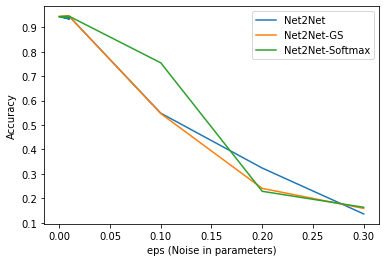

In [49]:
plt.plot(epses, np.mean(yplot, 0), label='Net2Net')
plt.plot(epses, np.mean(yplot2, 0), label='Net2Net-GS')
plt.plot(epses, np.mean(yplot3, 0), label='Net2Net-Softmax')
plt.legend(loc='best')
plt.xlabel('eps (Noise in parameters)')
plt.ylabel('Accuracy')